# Classification with trained fully-convolutional neural network

In [61]:
import numpy as np
import os
import pandas as pd
import torch

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.lines import Line2D

from uxo_cnn_classification import (
    SurveyParameters, classify_data,
    classify_cell, clean_background,
    get_diglist, mask_polygon,
    load_sensor_info
)

In [62]:
from matplotlib import rcParams
rcParams['font.size'] = 14
rcParams['font.family'] = ['Lato']

In [63]:
save_figures = False  # overwrite the saved figures?
seeds = [4750, 5293, 9254]
training_seed = str(seeds[2]) # random seed used during training (to load parameters file and save figures and diglist)

In [64]:
# sequim 2022
class_dict = {
    0: "not TOI",
    1: "ISO Large",
    2: "Howitzer Replica",
    3: "105mm HEAT",
    4: "ISO Medium",
    5: "155mm Howitzer",
    6: "105mm M60",
    7: "81mm M821",
    8: "60mm M49",
    9: "40mm L70",
    10: "clutter0",
    11: "clutter1",
}
survpars = SurveyParameters(
    sensor_type = 'ultratema',
    ymax = 4.5,
    y_spacing = 0.3,
    min_standoff = 0.4,
    #noise_file = ''
)
train_case = 'sequim2022'
bg_case = 'a'
field_data_dir = "/home/jorge/Documents/notebooks/UXO_project/preprocessed_field_data" # pre-processed data
field_case = 'calib2022' # 'blind2022'

In [65]:
# only needed to load time channels:
synth_data_dir = f'/media/jorge/T7/data_{train_case}'

In [66]:
# load file with CNN trained parameters (must match "ConvNet" architecture):
netpars_directory = "cnn_parameters"
cnn_trained_pars = os.path.sep.join([netpars_directory, f"net{train_case}_{training_seed}.pth"]) 

In [67]:
# create results directory if it does not exist:
results_dir = os.path.join(os.getcwd(), 'results')

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [68]:
# origin in UTM coordinates (only needed to generate diglist)
x0_field = {
    'strath': (312922.18, 6100755.02),
    'calib2021': (497804.32, 5324514.16),
    'blind2021': (497802.3, 5324586.5),
    'calib2022': (497803.66, 5324608.39),
    'blind2022': (497804.83, 5324536.85)
}
x0 = np.array(x0_field[f'{field_case}'])

In [69]:
sensorinfo = load_sensor_info(survpars.sensor_type)
n_class = len(class_dict.keys())
ntx = sensorinfo.ntx
nrx = sensorinfo.nrx # number of receiver cubes
dy = survpars.y_spacing / ntx
nloc = int(survpars.ymax/dy)
ncycles = int(nloc/ntx)

In [70]:
times = np.load(os.path.sep.join([synth_data_dir, "times.npy"]))
ntimes = len(times)

In [71]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
if len(class_dict) > 10:
    tab10_list = [mpl.cm.tab10.colors[i] for i in range(10)]
    added_colors = [mpl.colors.to_rgb(c) for c in ["#ebb50a","lightgreen"]][:len(class_dict)-10] # added color to standard tab10
    my_cmap = ListedColormap(tab10_list + added_colors, name="my_cmap")
else:
    my_cmap = ListedColormap([mpl.cm.tab10.colors[i] for i in range(len(class_dict))], name="my_cmap")

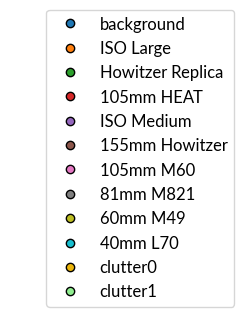

In [72]:
# show labels and colors:
fig, ax = plt.subplots(figsize=(3, n_class*0.2))

marker_size=6
mew = 1.0
custom_lines = [Line2D([0], [0], c="w", marker='o', ms=marker_size, mfc=my_cmap.colors[i], mec="k", lw=1.0, mew=mew) for i in range(len(class_dict))]

ax.axis('off')
ax.legend(custom_lines, ['background'] + list(class_dict.values())[1:], loc="lower right", fontsize=12)

## classify a line of synthetic data


In [73]:
data_profile = np.load(os.path.sep.join([synth_data_dir, "data_profile.npz"]))
x_profile = np.load(os.path.sep.join([synth_data_dir, "x_profile.npz"]))
y_profile = np.load(os.path.sep.join([synth_data_dir, "y_profile.npz"]))
params_profile = pd.read_hdf(os.path.sep.join([synth_data_dir, "params_profile.h5"]))

depths_profile = params_profile["depth"].to_numpy()

In [74]:
params_profile

,label,depth,x,y,z,yaw,pitch,roll,noise_amplitude,polarizations,clutter_type,pol_small,big_key,small_key
0,1,0.5,0,5,-0.5,0.0,0.000000,0,0.001,0,0,0,,
1,3,0.5,0,17,-0.5,0.0,0.000000,0,0.000,0,0,0,,
2,5,0.5,0,26,-0.5,0.0,1.570796,0,0.000,0,0,0,,
3,10,0.5,0,35,-0.5,0.0,0.000000,0,0.000,0,1,0,81mm,20mm


In [75]:
maxcat_lines, segprob_lines, classified_X, classified_Y = classify_data(survpars, class_dict, x_profile, y_profile, data_profile, times, cnn_trained_pars)

line:arr_0, sliding windows:136, classes output shape:(12, 150)


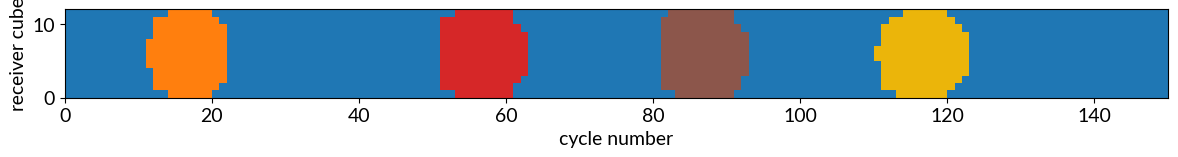

In [76]:
# classify by voting (most voted label in overlapping windows):
fig,ax = plt.subplots(figsize=(12,3.5))

ax.pcolormesh(maxcat_lines[0],vmin=0,vmax=n_class-1,cmap=my_cmap)
ax.set_aspect(1)
ax.set_ylabel('receiver cube')
ax.set_xlabel('cycle number')
fig.tight_layout()

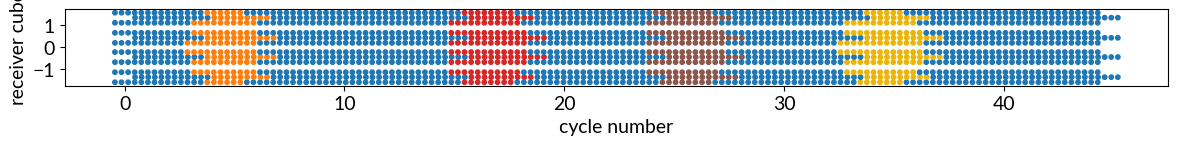

In [77]:
# send to corresponding receiver cubes positions:
fig, ax = plt.subplots(figsize=(12,4))

ax.scatter(classified_Y[0], classified_X[0], c=maxcat_lines[0], s=10.0, vmin=0,vmax=n_class-1,cmap=my_cmap)
ax.set_aspect(1)
#ax.set_ylim(-1.75,1.75)
ax.set_ylabel('receiver cube')
ax.set_xlabel('cycle number')
fig.tight_layout()

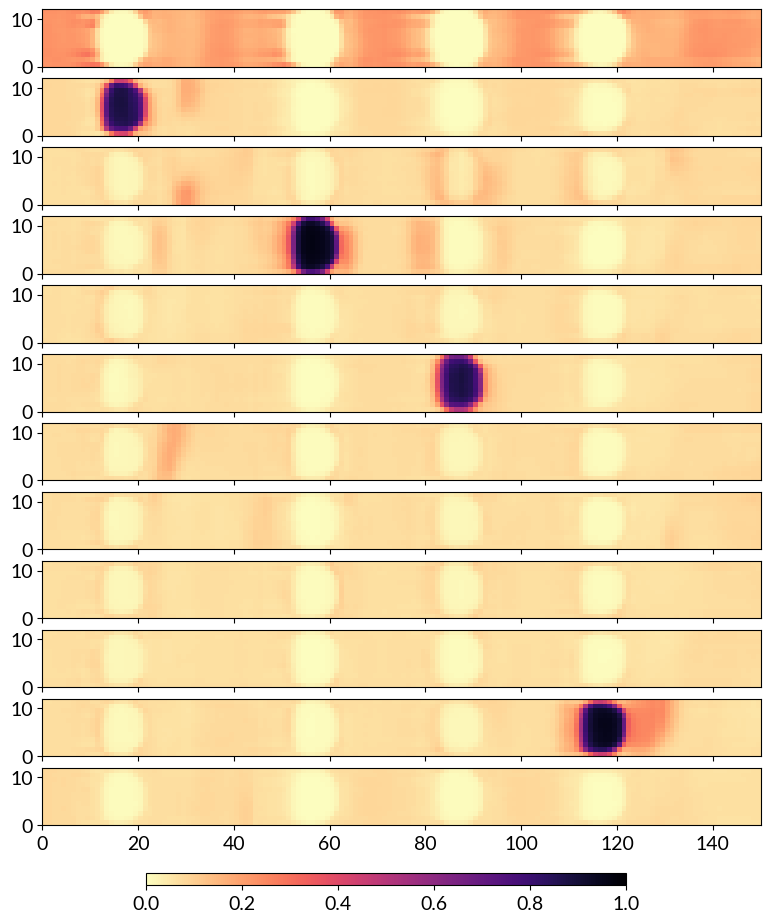

In [78]:
# probabilities for each class:
fig,ax = plt.subplots(n_class, 1, figsize=(12,n_class))

for i in range(n_class):
    cb = ax[i].pcolormesh(segprob_lines[0][i],vmin=0,vmax=1,cmap='magma_r')
    ax[i].set_aspect(1)
    
plt.setp(ax[:-1], xticklabels=[])    
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.01])
fig.colorbar(cb, cax=cbar_ax, orientation='horizontal')

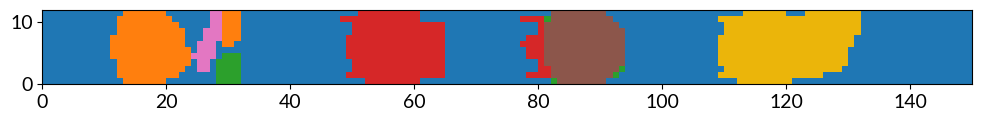

In [79]:
# classify by max prrobability:
fig,ax = plt.subplots(figsize=(12,3))

ax.pcolormesh(segprob_lines[0].argmax(axis=0),vmin=0,vmax=n_class-1,cmap=my_cmap)
ax.set_aspect(1)

## classify multiple lines field data

In [80]:
field_data = np.load(os.path.sep.join([field_data_dir, f"masked_data_{field_case}{bg_case}.npz"]))
field_x = np.load(os.path.sep.join([field_data_dir, f"masked_x_{field_case}.npz"]))
field_y = np.load(os.path.sep.join([field_data_dir, f"masked_y_{field_case}.npz"]))

In [81]:
classify_field, segprob_field, classified_X, classified_Y = classify_data(survpars, class_dict, field_x, field_y, field_data, times, cnn_trained_pars)

line:1001, sliding windows:279, classes output shape:(12, 293)
line:1002, sliding windows:282, classes output shape:(12, 296)
line:1003, sliding windows:280, classes output shape:(12, 294)
line:1004, sliding windows:286, classes output shape:(12, 300)
line:1005, sliding windows:274, classes output shape:(12, 288)
line:1006, sliding windows:283, classes output shape:(12, 297)
line:1007, sliding windows:275, classes output shape:(12, 289)


In [82]:
theta = 0.

In [83]:
synthetic_eastings  = np.cos(theta-np.pi/2) * np.hstack(classified_X).flatten() + np.sin(theta-np.pi/2) * np.hstack(classified_Y).flatten()  
synthetic_northings = -np.sin(theta-np.pi/2) * np.hstack(classified_X).flatten() + np.cos(theta-np.pi/2) * np.hstack(classified_Y).flatten()

In [84]:
def add_UXOs(ax,rotate=False):
    marker_size=4
    mew = 1.0
    for i, item in enumerate(groundtruth["Item"]): # 2022
    #for i, item in enumerate(synthetic_subset["ItemClass"]): # 2021
        x = groundtruth["Easting"][i] - x0[0]
        y = groundtruth["Northing"][i] - x0[1]
        if rotate:
            x_rot  = np.cos(theta-np.pi/2) * x + np.sin(theta-np.pi/2) * y  
            y_rot = -np.sin(theta-np.pi/2) * x + np.cos(theta-np.pi/2) * y
        else:
            x_rot = x
            y_rot = y
        if item in map_dict.keys():
            ax.plot(x_rot, y_rot, 'o', ms=marker_size, c=my_cmap.colors[map_dict[item]], mec="k", mew=mew) # 2022
        else:
            clutitem = 'clutter'
            ax.plot(x_rot, y_rot, 'o', ms=marker_size, c=my_cmap.colors[map_dict['clutter']], mec="k", mew=mew) # 2022

In [85]:
def add_UXO_labels(ax,column,rotate=False):
    for i, item in enumerate(groundtruth[column]):
        x = groundtruth["Easting"][i] - x0[0]
        y = groundtruth["Northing"][i] - x0[1]
        if rotate:
            x_rot  = np.cos(theta-np.pi/2) * x + np.sin(theta-np.pi/2) * y  
            y_rot = -np.sin(theta-np.pi/2) * x + np.cos(theta-np.pi/2) * y
        else:
            x_rot = x
            y_rot = y
        #if item > 0.0:
        ax.annotate(item, (x_rot+0.5, y_rot-0.5), size=8)#,bbox=dict(boxstyle="square,pad=0.1", fc="w", ec="k", lw=0))

In [86]:
def add_UXO_legend(ax):
    marker_size=6
    mew = 1.0
    custom_lines = [Line2D([0], [0], c="w", marker='o', ms=marker_size, mfc=my_cmap.colors[i], mec="k", lw=1.0, mew=mew) for i in range(len(class_dict))]
    
    ax.legend(custom_lines, ['background'] + list(class_dict.values())[1:], fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))#,"Railway"])

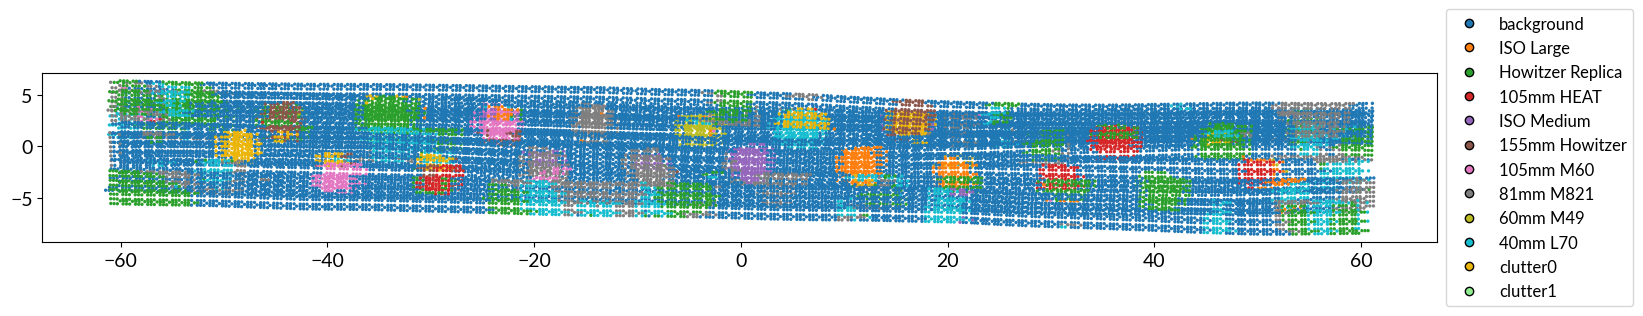

In [87]:
nplots = len(classify_field)
fig, ax = plt.subplots(figsize=(18,12))

for i in range(nplots):
    clb = ax.scatter(classified_X[i], classified_Y[i],c=classify_field[i],vmin=0,vmax=n_class-1,cmap=my_cmap,s=2.0)
#add_UXOs(ax)
#add_UXO_labels(ax,"Item") # 2022
#add_UXO_labels(ax,"ItemClass") # 2021
add_UXO_legend(ax)
#ax.plot(polygon[:,0],polygon[:,1],'k',lw=2.0)
#ax.set_xlim((-60,60)) #ax.set_xlim((-50,50))
#ax.set_ylim((-60,60)) #ax.set_ylim((-40,40))
ax.set_aspect(1.0)
#fig.colorbar(clb)

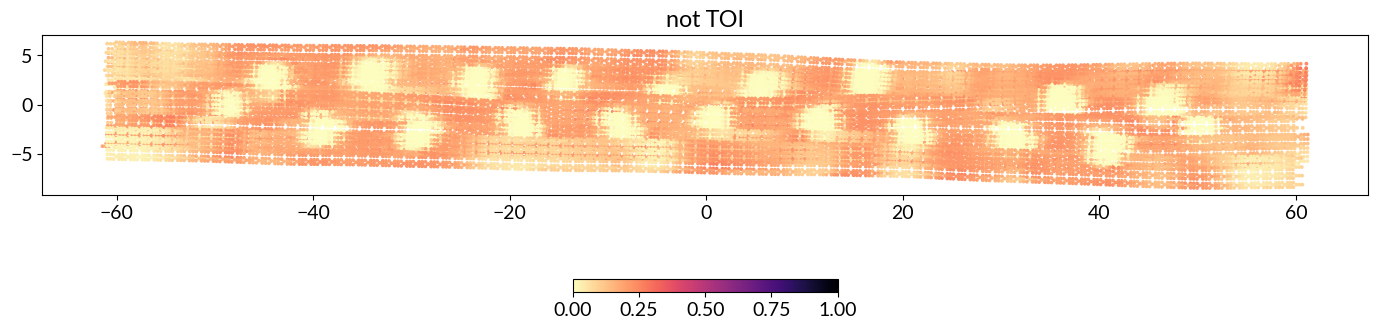

In [88]:
nlines = len(classify_field)
fig, ax = plt.subplots(figsize=(14,6))

j = 0
a = ax
for i in range(nlines):
    cb = a.scatter(classified_X[i], classified_Y[i],c=segprob_field[i][j,:,:],vmin=0,vmax=1.0,cmap='magma_r',s=3.0)
#a.plot(polygon[:,0],polygon[:,1],'k',lw=2.0)
#a.set_xlim((-60,60)) #ax.set_xlim((-50,50))
#a.set_ylim((-60,60)) #ax.set_ylim((-40,40))
a.set_aspect(1.0)
a.set_title(class_dict[j])
        
fig.colorbar(cb,orientation='horizontal',shrink=0.2)
#add_UXOs(ax)
fig.tight_layout()

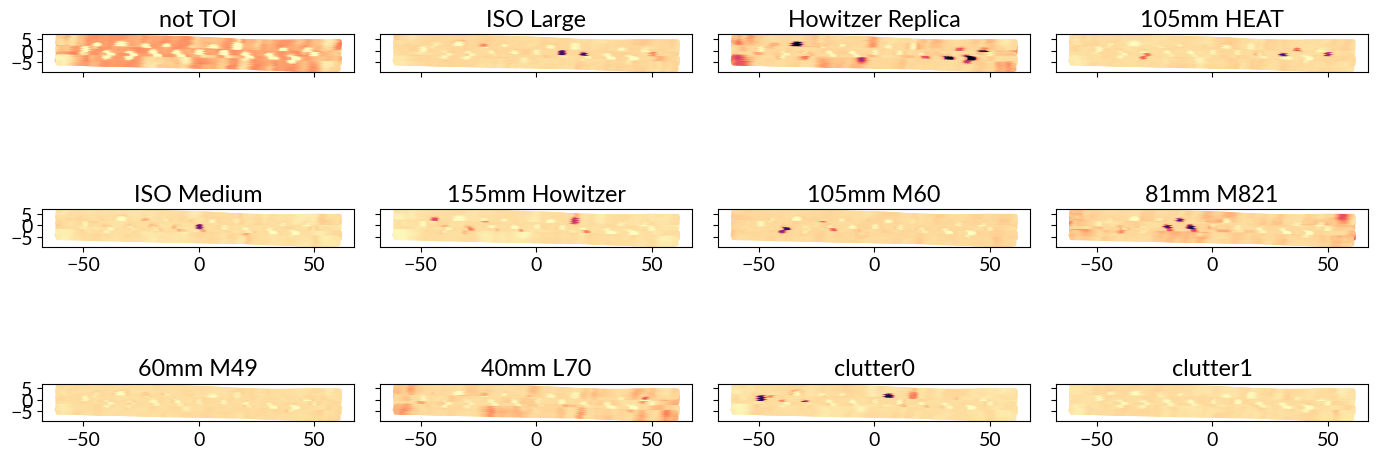

In [89]:
nlines = len(classify_field)
fig, ax = plt.subplots(3,4,figsize=(14,6))

ax = ax.flatten()
for j in range(n_class):
    a = ax[j]
    for i in range(nlines):
        cb = a.scatter(classified_X[i], classified_Y[i],c=segprob_field[i][j,:,:],vmin=0,vmax=1.0,cmap='magma_r',s=3.0)
        #a.plot(polygon[:,0],polygon[:,1],'k',lw=2.0)
    #a.set_xlim((-60,60)) #ax.set_xlim((-50,50))
    #a.set_ylim((-60,60)) #ax.set_ylim((-40,40))
    a.set_aspect(1.0)
    a.set_title(class_dict[j])
    if j%4 != 0:
        a.set_yticklabels('')
    if j<4:
        a.set_xticklabels('')
        
#fig.colorbar(cb,orientation='horizontal',shrink=0.2)
#add_UXOs(ax)
fig.tight_layout()

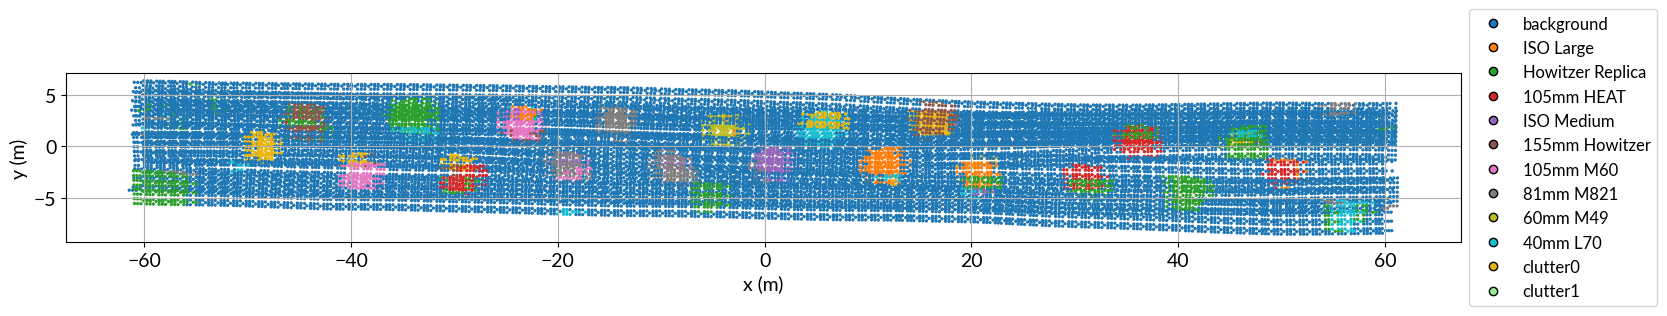

In [90]:
nlines = len(classify_field)
fig, ax = plt.subplots(figsize=(18,5))

class_not_bg = clean_background(classify_field, segprob_field, threshold=0.05)

for i in range(nlines):
    #not_bg = np.logical_and(classify_field[i] != 0, segprob_field[i][0,:,:]<0.05) #and (segprob_field[i][])
    #class_not_bg = (classify_field[i]*not_bg.astype(int)).astype(int)
    cb = ax.scatter(classified_X[i], classified_Y[i],c=class_not_bg[i],vmin=0,vmax=n_class-1,cmap=my_cmap,s=2.0)
    #ax.plot(polygon[:,0],polygon[:,1],'k',lw=2.0)
    #add_UXOs(ax)

    add_UXO_legend(ax)
    #add_UXO_labels(ax,"Item") # 2022
    ax.set_aspect(1.0)
    #ax.set_xlim((-60,60)) #ax.set_xlim((-50,50))
    #ax.set_ylim((-60,60)) #ax.set_ylim((-40,40))
    ax.set_aspect(1.0)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.grid(True)
#fig.colorbar(cb,orientation='horizontal',shrink=0.2)

In [60]:
fig.savefig(os.path.join(results_dir, f'classified_{field_case}{bg_case}_{training_seed}.png'))

## Divide in cells to get probabilities:

In [ ]:
# load polygon array (num. of cells x num. of vertices of areas x 2)
polygon_array = np.load(f'cells_sequim{field_case}.npy')

In [ ]:
nlines = len(classify_field)
fig, ax = plt.subplots(figsize=(10,10))

for i in range(nlines):
    cb = ax.scatter(classified_X[i], classified_Y[i],c=class_not_bg[i],vmin=0,vmax=n_class-1,cmap=my_cmap,s=3.0)
    for j,pol in enumerate(polygon_array):
        ax.plot(pol[:,0],pol[:,1],'k',lw=1.0)
        ax.annotate(f'{j}', (pol[:,0].mean()-0.5, pol[:,1].mean()-0.5),size=10)
    #add_UXOs(ax)
    #ax.plot(polygon[:,0],polygon[:,1],'k',lw=2.0)
    #add_UXOs(ax)
    add_UXO_legend(ax)
    ax.set_aspect(1.0)
    #ax.set_xlim((-60,60)) #ax.set_xlim((-50,50))
    #ax.set_ylim((-60,60)) #ax.set_ylim((-40,40))
    ax.set_aspect(1.0)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
#fig.colorbar(cb,orientation='horizontal',shrink=0.2)

In [ ]:
x_cell, y_cell, prob_cell = classify_cell(polygon_array, classify_field, segprob_field, classified_X, classified_Y)

In [ ]:
# single cell plot:
cell_ind = 0

cell = polygon_array[cell_ind,:,:]
xm,ym,classified_field_m,prob_m = mask_polygon(cell, classified_X, classified_Y, class_not_bg, segprob_field)

nlines = len(classify_field)
fig, ax = plt.subplots(1,n_class,figsize=(16,4))

for j in range(n_class):
    a = ax[j]
    for i in range(nlines):
        clb = a.scatter(xm[i], ym[i],c=prob_m[i][j,:],vmin=0,vmax=1.0,cmap='magma_r',s=10.0)
        #clb = a.scatter(xm[i], ym[i],c=classified_field_m[i],vmin=0,vmax=n_class-1,cmap=my_cmap,s=3.0)
    a.plot(cell[:,0],cell[:,1],'k',lw=2.0)
    a.set_xlabel(f'{prob_cell[cell_ind,j]:.2}')
    a.set_title(class_dict[j])
    a.set_aspect(1.0)
    #fig.colorbar(clb)

In [ ]:
results, diglist = get_diglist(x_cell, y_cell, prob_cell, class_dict, x0, safety_threshold=0.3)

In [ ]:
diglist

In [ ]:
#diglist.to_excel(os.path.join(results_dir, f'diglist_sequimblind2022_{training_seed}.xlsx'))

In [ ]:
# plot classified and final labels after cell processing:
nlines = len(classify_field)
fig, ax = plt.subplots(figsize=(12,12))

for i in range(nlines):
    cb = ax.scatter(classified_X[i], classified_Y[i],c=class_not_bg[i],vmin=0,vmax=n_class-1,cmap=my_cmap,s=3.0)
ax.scatter(x_cell,y_cell,c='k',marker='x')
for i,(xi,yi) in enumerate(zip(x_cell,y_cell)):
    ax.annotate(results.at[i,'obj_corr'], (xi+0.5,yi+0.5),size=10,weight='bold')
#add_UXOs(ax)
add_UXO_legend(ax)
ax.plot(polygon[:,0],polygon[:,1],'k',lw=2.0)
ax.set_aspect(1.0)
#ax.set_xlim((-60,60)) #ax.set_xlim((-50,50))
#ax.set_ylim((-60,60)) #ax.set_ylim((-40,40))
ax.set_aspect(1.0)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
#fig.colorbar(cb,orientation='horizontal',shrink=0.2)

In [ ]:
#fig.savefig(os.path.join(results_dir, f'finallabel_{field_case}{bg_case}_{training_seed}.png'))

In [ ]:
#results.sort_index().to_excel(os.path.join(results_dir, f'results_{field_case}{bg_case}_{training_seed}.xlsx'))